In [ ]:
!pip3 install torch
!pip3 install transformers
!pip3 install scikit-learn
!pip3 install matplotlib

from transformers import BertForMaskedLM, BertTokenizer, pipeline
from transformers import AutoModel, AutoTokenizer
from sklearn.manifold import TSNE
from google.colab import drive
import torch, os, polars as pl, pandas as pd, random, matplotlib.pyplot as plt, numpy as np, shutil
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import time, random
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.1 MB/s eta 0:00:00


In [ ]:
#@title Mount drive
drive.mount('/content/drive/')
path = '/content/drive/MyDrive/msc-project-mbalmf01/all_paired'
os.chdir(path)
os.listdir()

Mounted at /content/drive/


['Miniconda3-py39_23.3.1-0-Linux-x86_64.sh',
 'Miniconda3-py39_23.3.1-0-Linux-x86_64.sh.1',
 '230604_human_paired_seqs.csv',
 '230604_random_100.csv',
 'opig_data',
 '230618_human_paired_seqs.csv',
 'paired_human.fasta',
 '230624_test.csv',
 '230625_human_paired_seqs.csv',
 '230625_paired_rand1000.csv']

In [ ]:
def str_replace(insert: str, s: str, i: int) -> str:
  s = list(s)
  val = s[i]
  s[i] = insert
  print(val)
  return ''.join(s)

def masked_string_to_list(s: str) -> list:
  mask = '[MASK]'
  s = s.split(mask)
  s = '!'.join(s)
  s = list(s)
  s = list(map(lambda x: x.replace('!', '[MASK]'), s))
  return s

def get_sequence_embeddings(encoded_input, model_output):
  '''
  Taken from Ablang paper - may not work on other pLMs
  '''
  mask = encoded_input['attention_mask'].float()
  d = {k: v for k, v in torch.nonzero(mask).cpu().numpy()} # dict of sep tokens
  # make sep token invisible
  for i in d:
      mask[i, d[i]] = 0
  mask[:, 0] = 0.0 # make cls token invisible
  mask = mask.unsqueeze(-1).expand(model_output.last_hidden_state.size())
  sum_embeddings = torch.sum(model_output.last_hidden_state * mask, 1)
  sum_mask = torch.clamp(mask.sum(1), min=1e-9)
  return sum_embeddings / sum_mask

def get_rost_embeddings(encoded_input, model_output):
  '''
  Modified from Ablang paper to work on ProtBert - may not work on other pLMs
  '''
  mask = encoded_input['attention_mask'].float()
  d = {k: v for k, v in torch.nonzero(mask).cpu().numpy()} # dict of sep tokens
  # make sep token invisible
  for i in d:
      mask[i, d[i]] = 0
  mask[:, 0] = 0.0 # make cls token invisible
  # Access the logits tensor
  logits = model_output.logits
  mask = encoded_input['attention_mask'].unsqueeze(-1).expand(logits.size())
  sum_embeddings = torch.sum(logits * mask, 1)
  sum_mask = torch.clamp(mask.sum(1), min=1e-9)
  return sum_embeddings / sum_mask

def add_embeddings(antibody: str, model, tokenizer, fun) -> list:
  antibody = ' '.join(antibody)
  encoded_input = tokenizer(antibody, return_tensors='pt')
  model_output = model(**encoded_input)
  seq_embeds = fun(encoded_input, model_output)
  return seq_embeds

In [ ]:
df = pd.read_csv('230625_human_paired_seqs.csv', dtype={'Run':np.str_})

l = random.choices([i for i in range(df.shape[0])], k=1000)

df = df.iloc[l]

df.columns

Index(['Unnamed: 0', 'sequence_id_heavy', 'ANARCI_status_heavy',
       'sequence_heavy', 'sequence_alignment_aa_heavy', 'v_call_heavy',
       'd_call_heavy', 'j_call_heavy', 'sequence_id_light',
       'ANARCI_status_light', 'sequence_light', 'v_call_light', 'j_call_light',
       'sequence_alignment_aa_light', 'Run', 'seq_id'],
      dtype='object')

In [ ]:
df.to_csv('230625_paired_rand1000.csv')

In [ ]:
s = 'EVQLQESGPGLVKPSETLSLTCTVSGGPINNAYWTWIRQPPGKGLEYLGYVYHTGVTNYNPSLKSRLTITIDTSRKQLSLSLKFVTAADSAVYYCAREWAEDGDFGNAFHVWGQGTMVAVSSASTKGPSVFPLAPSSKSTSGGTAALGCL'
s = str_replace('[MASK]', s, 8)
s = masked_string_to_list(s)
s = ' '.join(s)
print(s)

P
E V Q L Q E S G [MASK] G L V K P S E T L S L T C T V S G G P I N N A Y W T W I R Q P P G K G L E Y L G Y V Y H T G V T N Y N P S L K S R L T I T I D T S R K Q L S L S L K F V T A A D S A V Y Y C A R E W A E D G D F G N A F H V W G Q G T M V A V S S A S T K G P S V F P L A P S S K S T S G G T A A L G C L


ProtBert from the Rost lab

In [ ]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
model = BertForMaskedLM.from_pretrained("Rostlab/prot_bert")

unmasker = pipeline('fill-mask', model=model, tokenizer=tokenizer)
unmask = unmasker(s)
d = unmask[0]['token_str']
print(d)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


P


In [ ]:
encoded_input = tokenizer(s, return_tensors='pt')
model_output = model(**encoded_input)
seq_embeds = get_rost_embeddings(encoded_input, model_output)

In [ ]:
seq_embeds[0]

tensor([-19.4885, -19.6998, -19.6725, -22.5122, -20.8836,  -0.0964,   0.1421,
         -0.2609,  -0.1108,  -1.3770,   0.9179,  -1.1048,  -1.8446,  -0.9713,
         -1.6025,   0.1615,  -1.2221,  -1.5307,  -1.4581,  -1.7030,  -1.7993,
         -2.0830,  -2.0889,  -2.6327,  -2.7469,  -4.5330, -18.9325, -19.5515,
        -19.4415, -19.4562], grad_fn=<SelectBackward0>)

In [ ]:
import numpy as np

for h in range(0, 100, 5):
  tensors = {}
  for i in range(h, h+5):
    j = df['sequence_heavy'].iloc[i]

    tensor = add_embeddings(antibody=j,
                  model=model,
                  tokenizer=tokenizer,
                  fun=get_rost_embeddings)

    tensors[df['seq_id'].iloc[i]] = tensor.detach.numpy()

  test = pd.DataFrame([tensors])
  test.to_csv(f'230629_tensors_{h}.csv')


In [ ]:
pd.DataFrame([tensors]).transpose()

,0
TGCCAAAGTTTGACTG-1_contig_1_TGCCAAAGTTTGACTG-1_contig_2_1287154,"[[tensor(-19.3405, grad_fn=<UnbindBackward0>),..."
TACGGATTCTATGTGG-1_contig_1_TACGGATTCTATGTGG-1_contig_2_SRR12875355,"[[tensor(-19.2527, grad_fn=<UnbindBackward0>),..."
GTTCTCGGTCCCGACA-1_contig_1_GTTCTCGGTCCCGACA-1_contig_2_1287155,"[[tensor(-19.2148, grad_fn=<UnbindBackward0>),..."
GGACAGAAGGTGCTTT-1_contig_2_GGACAGAAGGTGCTTT-1_contig_1_1287144,"[[tensor(-19.1780, grad_fn=<UnbindBackward0>),..."
ACGATGTGTTGTACAC-1_contig_1_ACGATGTGTTGTACAC-1_contig_2_1287171,"[[tensor(-19.1702, grad_fn=<UnbindBackward0>),..."


Ablang from the Deane lab - note that heavy and light should be imported separately here, so will not handle paired sequences.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('qilowoq/AbLang_heavy')
model = AutoModel.from_pretrained('qilowoq/AbLang_heavy', trust_remote_code=True)

A new version of the following files was downloaded from https://huggingface.co/qilowoq/AbLang_heavy:
- AbLang_roberta_model.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Some weights of the model checkpoint at qilowoq/AbLang_heavy were not used when initializing RobertaModelV2: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModelV2 from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModelV2 from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
antibody = ' '.join("EVQLQESGPGLVKPSETLSLTCTVSGGPINNAYWTWIRQPPGKGLEYLGYVYHTGVTNYNPSLKSRLTITIDTSRKQLSLSLKFVTAADSAVYYCAREWAEDGDFGNAFHVWGQGTMVAVSSASTKGPSVFPLAPSSKSTSGGTAALGCL")
encoded_input = tokenizer(antibody, return_tensors='pt')
model_output = model(**encoded_input)
seq_embeds = get_sequence_embeddings(encoded_input, model_output)

In [ ]:
seq_embeds

tensor([[-5.5471e-01, -8.1645e-01, -9.3432e-01,  2.0327e-01, -4.7224e-01,
         -6.0342e-02,  7.2227e-01,  2.3692e-01, -5.4165e-01, -6.9008e-01,
          2.0944e-01, -2.6239e-01, -7.0872e-01, -2.8236e-01, -1.8056e-01,
         -8.0409e-01, -6.9359e-01,  3.6179e-02,  5.5190e-01,  5.4110e-01,
         -1.5253e-01,  2.8848e-01,  1.2818e-01,  4.3357e-01,  7.0432e-02,
         -7.4300e-02,  7.4010e-01,  6.8917e-01,  2.5369e-01,  4.8095e-02,
         -2.3809e-01, -3.5762e-01,  4.9409e-01, -3.6832e-01,  1.4942e+00,
          3.0821e-01,  4.2052e-02, -1.2474e-01, -3.5971e-01, -2.3608e-01,
          7.9990e-04, -2.3614e-01,  6.3907e-01, -7.5474e-02,  7.3786e-01,
          5.6829e-02, -2.1010e-01,  2.2662e-01,  7.6908e-01, -6.6085e-01,
         -9.3319e-01, -3.8658e-02,  5.6689e-01,  9.1328e-01,  1.9997e-02,
          6.1361e-01, -2.9352e-01, -8.1569e-02,  6.1740e-01, -1.6157e-01,
         -4.6306e-01,  1.5679e-01, -8.7070e-01, -1.1334e+00, -8.6999e-02,
         -4.7576e-01,  2.9838e-01, -2.

In [ ]:
antibody = ' '.join("EVQLQESGPGLVKPSETLSLTCTVSGGPINNAYWTWIRQPPGKGLEYLGYVYHTGVTNYNPSLKSRLTITIDTSRKQLSLSLKFVTAADSAVYYCAREWAEDGDFGNAFHVWGQGTMVAVSSASTKGPSVFPLAPSSKSTSGGTAALGCL")
encoded_input = tokenizer(antibody, return_tensors='pt')
model_output = model(**encoded_input)
seq_embeds = get_sequence_embeddings(encoded_input, model_output)

start = time.time()
df['seq_embeddings'] = df['heavy'].apply(lambda x: add_embeddings(antibody=x, model=model, tokenizer=tokenizer, fun=get_sequence_embeddings))
end = time.time() - start

print(end)


37.20312690734863


In [ ]:
df.head()

,Unnamed: 0,0,1,heavy,light,seq_embeddings
0,666,TGCGTGGTCCTCAATT-1_contig_1_1287204,EVQLVESGGGLVQPGGSLRLSCTVSGFTFSSYSMNWVRQAPGKGLE...,EVQLVESGGGLVQPGGSLRLSCTVSGFTFSSYSMNWVRQAPGKGLE...,EIAMTQSPATLSVSPGERVTLSCRASQSISSNLAWYQQKPGQAPWL...,"[[tensor(-0.7001, grad_fn=<UnbindBackward0>), ..."
1,2564,GACGTTAAGCAAATCA-1_contig_2_1279080,QVLLMTSGAEVKKPGSSVTVSCKASGGSFSAFGVSWVRQAPEKGLE...,QVLLMTSGAEVKKPGSSVTVSCKASGGSFSAFGVSWVRQAPEKGLE...,EIVLTQSPRTLSLSPGERATLSCRASQSVSSKSLAWYQQKPGQAPT...,"[[tensor(-0.5727, grad_fn=<UnbindBackward0>), ..."
2,2721,ACCAGTAGTTACCAGT-1_contig_2_1279059,QITLKESGPTLVKTTQTLTLTCTFSGFSLSTSGVGVGWIRQPPGKA...,QITLKESGPTLVKTTQTLTLTCTFSGFSLSTSGVGVGWIRQPPGKA...,SYVLTQPPSVSVAPGETARITCGGNNIVSYSVHWYQQKAGQAPVLV...,"[[tensor(-0.2291, grad_fn=<UnbindBackward0>), ..."
3,3055,CGGAGCTCATCCGCGA-1_contig_2_1279059,QVQLQESGPGLVKPSQTLSLTCNVSDDSISRDFYYWNWVRQPAGKG...,QVQLQESGPGLVKPSQTLSLTCNVSDDSISRDFYYWNWVRQPAGKG...,EIVMTQSPFSLPVTPGEPASISCRSSQSLLHRKGYNCVDWYLQKPG...,"[[tensor(-0.4466, grad_fn=<UnbindBackward0>), ..."
4,3291,GGGATGATCATATCGG-1_contig_1_1279059,EVQLVESGGGLVQPGGSLRLSCEVAGFSIMSYRMQWIRQTPGKGLE...,EVQLVESGGGLVQPGGSLRLSCEVAGFSIMSYRMQWIRQTPGKGLE...,QSVLTQPPSASGTPGQRVTISCSGSSSNLGRNAVNWYQQLPGTAPK...,"[[tensor(-0.2778, grad_fn=<UnbindBackward0>), ..."


In [ ]:
#this code takes the tensors generated in a dataframe from antibody sequences and
#converts them into a single dataframe with the names of the sequences as column headers
#and the rows as the embeddings for each sequence

embeddings = df['seq_embeddings'].to_list()

embeddings = [e.detach().numpy()[0] for e in embeddings]
names = df['0'].to_list()

embeds = dict(zip(names, embeddings))
embeds = pd.DataFrame(embeds, columns=names)

embeds.shape

(768, 100)

Explained variation per principal component: [0.4275713  0.08930238 0.05585494]


<ipython-input-47-297e1fe08cde>:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


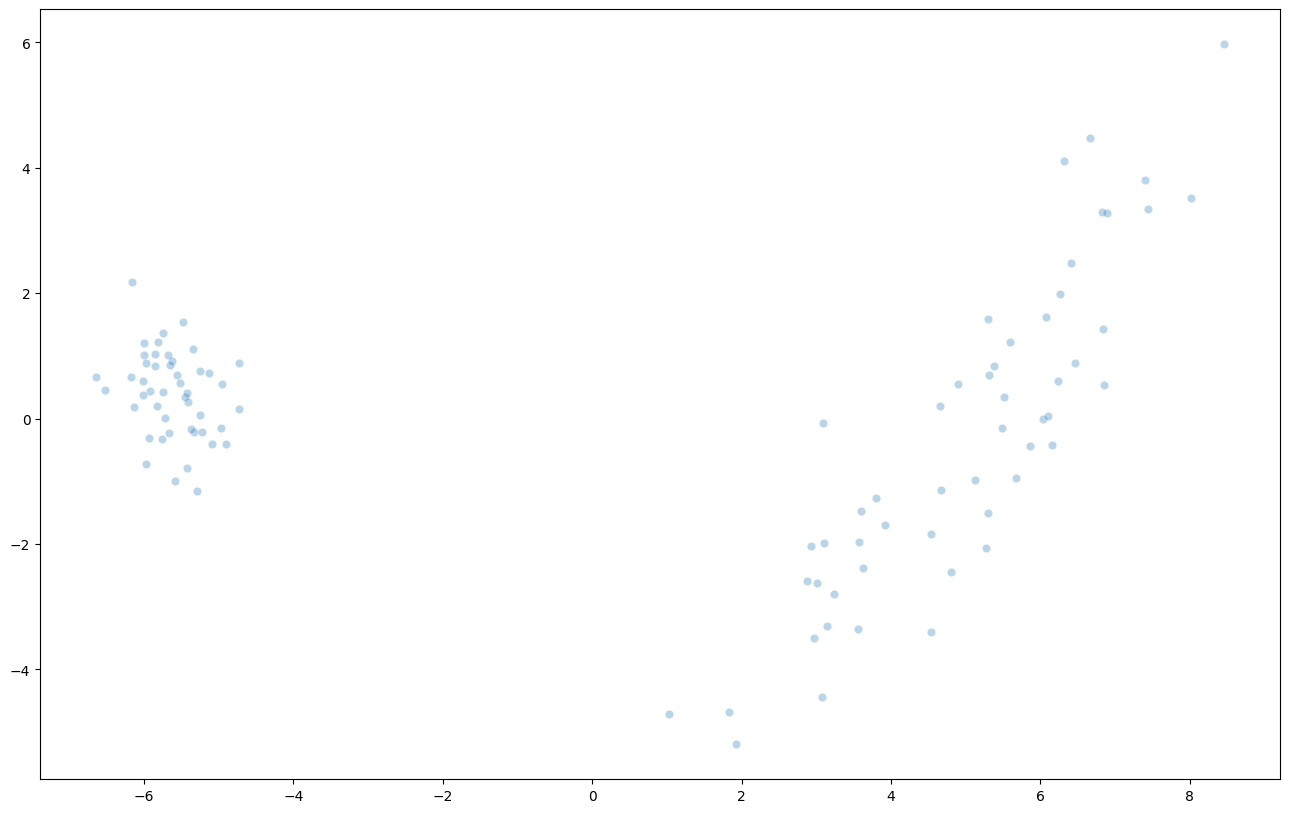

In [ ]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(embeds.transpose())
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_result[:,0], y=pca_result[:,2],
    palette=sns.color_palette("hls", 10),
    data=embeds.transpose(),
    legend="full",
    alpha=0.3
)

plt.show()


In [ ]:
embeddings[0].shape

(768,)

In [ ]:
# # # Reshape the embeddings to be 2D
# embeddings_2d = embeds.reshape(embeds.shape[0], -1)

# Perform dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeds.transpose())

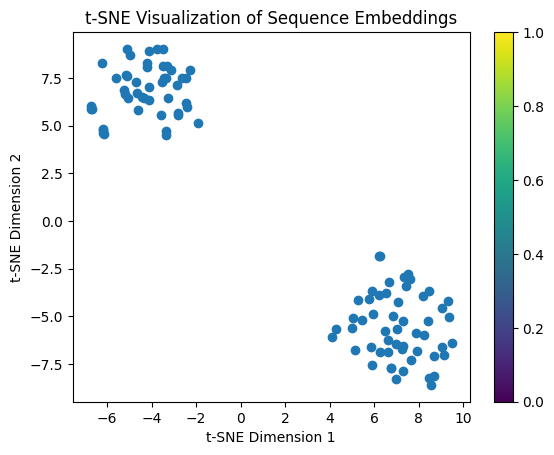

In [ ]:
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Sequence Embeddings')
plt.colorbar()
plt.show()

In [ ]:
df.to_csv('230624_test.csv')